In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [5]:
# Loading in the dataset with all team statistics
stats0 = pd.read_csv("CMSE_830_Midterm_dataset1.csv")
stats = stats0.drop(columns=['penalties', 'penalties_yds','pen_fd','ties','mov']) # dropping unnecessary columns
print(stats.columns)
stats.head(5)


Index(['year', 'team', 'wins', 'losses', 'win_loss_perc', 'points',
       'points_opp', 'points_diff', 'g', 'total_yards', 'plays_offense',
       'yds_per_play_offense', 'turnovers', 'fumbles_lost', 'first_down',
       'pass_cmp', 'pass_att', 'pass_yds', 'pass_td', 'pass_int',
       'pass_net_yds_per_att', 'pass_fd', 'rush_att', 'rush_yds', 'rush_td',
       'rush_yds_per_att', 'rush_fd', 'score_pct', 'turnover_pct',
       'exp_pts_tot'],
      dtype='object')


,year,team,wins,losses,win_loss_perc,points,points_opp,points_diff,g,total_yards,...,pass_net_yds_per_att,pass_fd,rush_att,rush_yds,rush_td,rush_yds_per_att,rush_fd,score_pct,turnover_pct,exp_pts_tot
0,2003,New England Patriots,14,2,0.875,348,238,110,16,5039,...,6.0,177,473,1607,9,3.4,91,27.9,11.3,-136.51
1,2003,Miami Dolphins,10,6,0.625,311,261,50,16,4609,...,5.8,145,487,1817,14,3.7,99,28.1,17.2,-177.92
2,2003,Buffalo Bills,6,10,0.375,243,279,-36,16,4348,...,4.9,150,427,1664,13,3.9,96,21.9,17.6,-230.07
3,2003,New York Jets,6,10,0.375,283,299,-16,16,4951,...,6.3,181,409,1635,8,4.0,78,32.4,11.8,-107.89
4,2003,Baltimore Ravens,10,6,0.625,391,281,110,16,4929,...,4.9,121,552,2674,18,4.8,115,31.8,16.6,-220.50


In [6]:
# Loading in dataset with penalty statistics
flags = pd.read_csv("CMSE_830_Midterm_dataset2.csv")
flags.head(5)

,Away_Team,Home_Team,Date,Ref_Crew,Accepted_Count,Yards,Away_Count,Away_Yards,Home_Count,Home_Yards,Total_Flags,Week,Year
0,Tennessee,Pittsburgh,09/10/2009,Bill Leavy,11,88,5,28,6,60,13,1,2009
1,Miami,Atlanta,09/13/2009,Walt Coleman,8,62,4,27,4,35,11,1,2009
2,Kansas City,Baltimore,09/13/2009,Gene Steratore,11,80,3,15,8,65,14,1,2009
3,Philadelphia,Carolina,09/13/2009,Jeff Triplette,14,106,9,76,5,30,14,1,2009
4,Denver,Cincinnati,09/13/2009,Jerome Boger,10,66,6,39,4,27,12,1,2009


In [7]:
# Cleaning and reformatting the flags dataset to combine with the team stats dataset
home_flags = flags.copy() 
away_flags = flags.copy() 

# searating the dataset into home and away statistics
home_flags = home_flags[['Home_Team','Accepted_Count','Yards','Home_Count','Home_Yards','Year']]
away_flags = away_flags[['Away_Team','Accepted_Count','Yards','Away_Count','Away_Yards','Year']]

home_flags

,Home_Team,Accepted_Count,Yards,Home_Count,Home_Yards,Year
0,Pittsburgh,11,88,6,60,2009
1,Atlanta,8,62,4,35,2009
2,Baltimore,11,80,8,65,2009
3,Carolina,14,106,5,30,2009
4,Cincinnati,10,66,4,27,2009
...,...,...,...,...,...,...
3577,Washington,8,44,5,24,2022
3578,Las Vegas,15,120,6,49,2022
3579,Seattle,7,35,5,25,2022
3580,Green Bay,9,65,3,30,2022


In [8]:
# concatenating the data into whole season numbers for both home and away datasets
home_flags1 = home_flags.groupby(['Home_Team', 'Year']).agg(
    Accepted_Penalty_Count=('Accepted_Count', 'sum'),
    Penalty_Yards=('Yards', 'sum'), 
    Team_Penalty_Count=('Home_Count', 'sum'),
    Team_Penalty_Yards=('Home_Yards', 'sum')
).reset_index()

away_flags1 = away_flags.groupby(['Away_Team', 'Year']).agg(
    Accepted_Penalty_Count=('Accepted_Count', 'sum'),
    Penalty_Yards=('Yards', 'sum'), 
    Team_Penalty_Count=('Away_Count', 'sum'),
    Team_Penalty_Yards=('Away_Yards', 'sum')
).reset_index()

# Combining the home and away datasets and combining the column values
home_flags1 = home_flags1.rename(columns={'Home_Team': 'Team'})
away_flags1 = away_flags1.rename(columns={'Away_Team': 'Team'})

combined = pd.concat([home_flags1, away_flags1], ignore_index=True)

flags = combined.groupby(['Team', 'Year'], as_index=False).sum(numeric_only=True)

flags

,Team,Year,Accepted_Penalty_Count,Penalty_Yards,Team_Penalty_Count,Team_Penalty_Yards
0,Arizona,2009,212,1726,108,886
1,Arizona,2010,216,1764,108,870
2,Arizona,2011,228,1947,105,982
3,Arizona,2012,202,1667,102,857
4,Arizona,2013,207,1704,96,744
...,...,...,...,...,...,...
443,Washington,2018,217,1799,115,1008
444,Washington,2019,200,1640,106,835
445,Washington,2020,172,1405,87,697
446,Washington,2021,172,1496,79,714


In [9]:
# taking a look at the different ways the datasets name the teams
print(flags['Team'].unique())
print(stats['team'].unique())

['Arizona' 'Atlanta' 'Baltimore' 'Buffalo' 'Carolina' 'Chicago'
 'Cincinnati' 'Cleveland' 'Dallas' 'Denver' 'Detroit' 'Green Bay'
 'Houston' 'Indianapolis' 'Jacksonville' 'Kansas City' 'LA Chargers'
 'LA Rams' 'Las Vegas' 'Miami' 'Minnesota' 'N.Y. Giants' 'N.Y. Jets'
 'New England' 'New Orleans' 'Oakland' 'Philadelphia' 'Pittsburgh'
 'San Diego' 'San Francisco' 'Seattle' 'St. Louis' 'Tampa Bay' 'Tennessee'
 'Washington']
['New England Patriots' 'Miami Dolphins' 'Buffalo Bills' 'New York Jets'
 'Baltimore Ravens' 'Cincinnati Bengals' 'Pittsburgh Steelers'
 'Cleveland Browns' 'Indianapolis Colts' 'Tennessee Titans'
 'Jacksonville Jaguars' 'Houston Texans' 'Kansas City Chiefs'
 'Denver Broncos' 'Oakland Raiders' 'San Diego Chargers'
 'Philadelphia Eagles' 'Dallas Cowboys' 'Washington Redskins'
 'New York Giants' 'Green Bay Packers' 'Minnesota Vikings' 'Chicago Bears'
 'Detroit Lions' 'Carolina Panthers' 'New Orleans Saints'
 'Tampa Bay Buccaneers' 'Atlanta Falcons' 'St. Louis Rams'
 'Seat

In [43]:
# creating a standard team naming system so the datasets can be combined
name_map = {
    # AFC East
    'New England': 'New England Patriots',
    'New England Patriots': 'New England Patriots',

    'Miami': 'Miami Dolphins',
    'Miami Dolphins': 'Miami Dolphins',

    'Buffalo': 'Buffalo Bills',
    'Buffalo Bills': 'Buffalo Bills',

    'N.Y. Jets': 'New York Jets',
    'NY Jets': 'New York Jets',
    'New York Jets': 'New York Jets',

    # AFC North
    'Baltimore': 'Baltimore Ravens',
    'Baltimore Ravens': 'Baltimore Ravens',

    'Cincinnati': 'Cincinnati Bengals',
    'Cincinnati Bengals': 'Cincinnati Bengals',

    'Pittsburgh': 'Pittsburgh Steelers',
    'Pittsburgh Steelers': 'Pittsburgh Steelers',

    'Cleveland': 'Cleveland Browns',
    'Cleveland Browns': 'Cleveland Browns',

    # AFC South
    'Indianapolis': 'Indianapolis Colts',
    'Indianapolis Colts': 'Indianapolis Colts',

    'Tennessee': 'Tennessee Titans',
    'Tennessee Titans': 'Tennessee Titans',
    'Houston Oilers': 'Tennessee Titans',  # historical

    'Jacksonville': 'Jacksonville Jaguars',
    'Jacksonville Jaguars': 'Jacksonville Jaguars',

    'Houston': 'Houston Texans',
    'Houston Texans': 'Houston Texans',

    # AFC West
    'Kansas City': 'Kansas City Chiefs',
    'Kansas City Chiefs': 'Kansas City Chiefs',

    'Denver': 'Denver Broncos',
    'Denver Broncos': 'Denver Broncos',

    'Oakland': 'Las Vegas Raiders',
    'Oakland Raiders': 'Las Vegas Raiders',
    'Los Angeles Raiders': 'Las Vegas Raiders',
    'Las Vegas': 'Las Vegas Raiders',
    'Las Vegas Raiders': 'Las Vegas Raiders',

    'San Diego': 'Los Angeles Chargers',
    'San Diego Chargers': 'Los Angeles Chargers',
    'LA Chargers': 'Los Angeles Chargers',
    'Los Angeles Chargers': 'Los Angeles Chargers',

    # NFC East
    'Philadelphia': 'Philadelphia Eagles',
    'Philadelphia Eagles': 'Philadelphia Eagles',

    'Dallas': 'Dallas Cowboys',
    'Dallas Cowboys': 'Dallas Cowboys',

    'Washington': 'Washington Commanders',
    'Washington Redskins': 'Washington Commanders',
    'Washington Football Team': 'Washington Commanders',
    'Washington Commanders': 'Washington Commanders',

    'N.Y. Giants': 'New York Giants',
    'NY Giants': 'New York Giants',
    'New York Giants': 'New York Giants',

    # NFC North
    'Green Bay': 'Green Bay Packers',
    'Green Bay Packers': 'Green Bay Packers',

    'Minnesota': 'Minnesota Vikings',
    'Minnesota Vikings': 'Minnesota Vikings',

    'Chicago': 'Chicago Bears',
    'Chicago Bears': 'Chicago Bears',

    'Detroit': 'Detroit Lions',
    'Detroit Lions': 'Detroit Lions',

    # NFC South
    'Carolina': 'Carolina Panthers',
    'Carolina Panthers': 'Carolina Panthers',

    'New Orleans': 'New Orleans Saints',
    'New Orleans Saints': 'New Orleans Saints',

    'Tampa Bay': 'Tampa Bay Buccaneers',
    'Tampa Bay Buccaneers': 'Tampa Bay Buccaneers',

    'Atlanta': 'Atlanta Falcons',
    'Atlanta Falcons': 'Atlanta Falcons',

    # NFC West
    'Arizona': 'Arizona Cardinals',
    'Arizona Cardinals': 'Arizona Cardinals',

    'Seattle': 'Seattle Seahawks',
    'Seattle Seahawks': 'Seattle Seahawks',

    'San Francisco': 'San Francisco 49ers',
    'San Francisco 49ers': 'San Francisco 49ers',

    'St. Louis': 'Los Angeles Rams',
    'St. Louis Rams': 'Los Angeles Rams',
    'LA Rams': 'Los Angeles Rams',
    'Los Angeles Rams': 'Los Angeles Rams',
}


# Applying mapping for both datasets to set standard naming convention
for col in ['team', 'Team']:  
    if col in stats.columns:
        stats[col] = stats[col].replace(name_map)
    if col in flags.columns:
        flags[col] = flags[col].replace(name_map)

stats = stats.rename(columns={'year': 'Year'})
stats = stats.rename(columns={'team': 'Team'})

# combining the two datasets by team and year
merged_df = pd.merge(flags, stats, on=['Team', 'Year'], how='outer')
merged_df.columns


Index(['Team', 'Year', 'Accepted_Penalty_Count', 'Penalty_Yards',
       'Team_Penalty_Count', 'Team_Penalty_Yards', 'wins', 'losses',
       'win_loss_perc', 'points', 'points_opp', 'points_diff', 'g',
       'total_yards', 'plays_offense', 'yds_per_play_offense', 'turnovers',
       'fumbles_lost', 'first_down', 'pass_cmp', 'pass_att', 'pass_yds',
       'pass_td', 'pass_int', 'pass_net_yds_per_att', 'pass_fd', 'rush_att',
       'rush_yds', 'rush_td', 'rush_yds_per_att', 'rush_fd', 'score_pct',
       'turnover_pct', 'exp_pts_tot'],
      dtype='object')

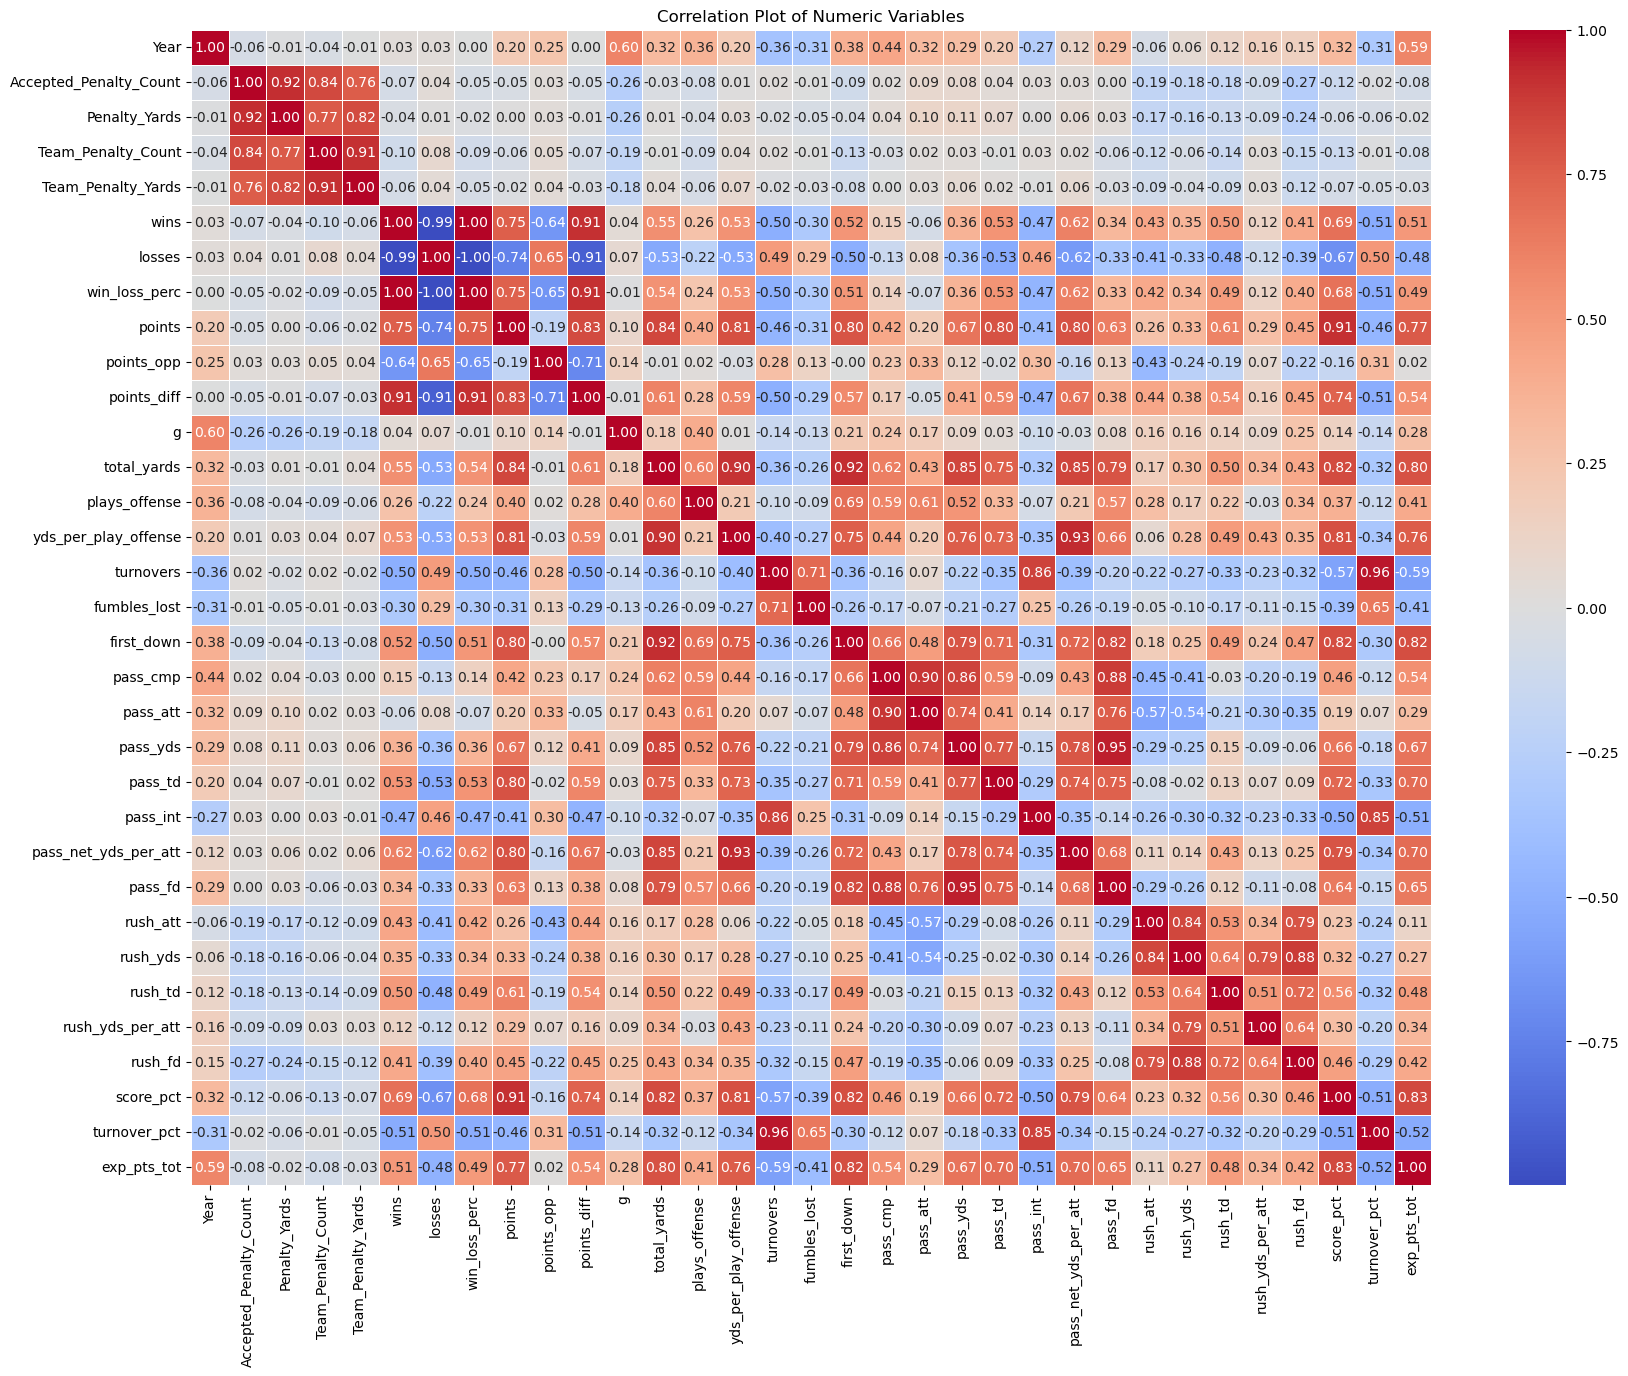

In [44]:
# doing an initial correlation check for all numeric columns
correlation_matrix = merged_df.corr(numeric_only=True)
plt.figure(figsize=(20, 15)) 
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Plot of Numeric Variables')
plt.show()

In [45]:
# taking a look at the whole dataframe to see what imputation will be needed
merged_df.info()
merged_df.to_csv("merged_df.csv", index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 672 entries, 0 to 671
Data columns (total 34 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Team                    672 non-null    object 
 1   Year                    672 non-null    int64  
 2   Accepted_Penalty_Count  448 non-null    float64
 3   Penalty_Yards           448 non-null    float64
 4   Team_Penalty_Count      448 non-null    float64
 5   Team_Penalty_Yards      448 non-null    float64
 6   wins                    672 non-null    int64  
 7   losses                  672 non-null    int64  
 8   win_loss_perc           672 non-null    float64
 9   points                  672 non-null    int64  
 10  points_opp              672 non-null    int64  
 11  points_diff             672 non-null    int64  
 12  g                       672 non-null    int64  
 13  total_yards             672 non-null    int64  
 14  plays_offense           672 non-null    in

In [13]:
# temporarily removing the team variable for imputation
Teams = merged_df[['Team']] 
merged_df = merged_df.drop(columns = ['Team'])

In [14]:
# setting a seed to the data doesn't change everytime the code is run
np.random.seed(42)

# making a copy so the original isn't overwritten
merged_df_imputed = merged_df.copy()

# Identifying numeric columns and those with NaNs
numeric_cols = merged_df_imputed.select_dtypes(include=[np.number]).columns
cols_with_na = [col for col in numeric_cols if merged_df_imputed[col].isna().any()]

# Looping through each column with missing data
for target_col in cols_with_na:

    # Defining predictors (exclude target column)
    X = merged_df_imputed.drop(columns=[target_col])
    y = merged_df_imputed[target_col]

    # Identifying missing and non-missing rows
    mask_missing = y.isna()
    mask_not_missing = ~mask_missing

    # Splitting into training and rows to impute
    X_train = X.loc[mask_not_missing]
    y_train = y.loc[mask_not_missing]
    X_missing = X.loc[mask_missing]

    # Skipping if not enough data
    if len(X_train) < 5 or X_missing.empty:
            print(f"⚠️ Skipping {target_col}: not enough valid data to train.")
            continue

    # Building a regression pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])

    # Fitting model on non-missing data
    pipeline.fit(X_train, y_train)

    # Making predictions for missing rows
    y_pred_mean = pipeline.predict(X_missing)

    # Computing residual std from training residuals
    residuals = y_train - pipeline.predict(X_train)
    residual_std = np.std(residuals)

    # Adding stochastic Gaussian noise
    noise = np.random.normal(0, residual_std, size=y_pred_mean.shape)
    y_pred_stochastic = y_pred_mean + noise

    # Filling in the missing values
    merged_df_imputed.loc[mask_missing, target_col] = y_pred_stochastic

    print(f" {target_col} residual std = {residual_std:.4f}")

 Accepted_Penalty_Count residual std = 5.9150
 Penalty_Yards residual std = 52.3693
 Team_Penalty_Count residual std = 4.1602
 Team_Penalty_Yards residual std = 38.1223


In [15]:
# replacing the team vairable and showing the newly imputed dataframe
merged_df_imputed[['Team']] = Teams
merged_df_imputed

,Year,Accepted_Penalty_Count,Penalty_Yards,Team_Penalty_Count,Team_Penalty_Yards,wins,losses,win_loss_perc,points,points_opp,...,pass_fd,rush_att,rush_yds,rush_td,rush_yds_per_att,rush_fd,score_pct,turnover_pct,exp_pts_tot,Team
0,2003,204.903927,1720.040391,100.579050,813.438335,4,12,0.250,225,452,...,147,403,1531,5,3.8,80,22.2,18.4,-250.75,Arizona Cardinals
1,2004,200.722704,1841.097107,89.267601,781.557459,6,10,0.375,284,322,...,152,475,1668,15,3.5,86,25.5,13.5,-202.74,Arizona Cardinals
2,2005,208.161658,1728.564374,102.860667,812.559178,5,11,0.313,311,387,...,224,360,1138,2,3.2,58,34.0,18.0,-175.55,Arizona Cardinals
3,2006,210.825930,1712.635919,109.304057,847.725125,5,11,0.313,314,389,...,187,419,1338,12,3.2,84,32.2,15.3,-95.61,Arizona Cardinals
4,2007,200.935587,1683.340170,98.463715,766.193066,8,8,0.500,404,399,...,210,402,1440,9,3.6,70,32.0,18.3,-176.41,Arizona Cardinals
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,2019,200.000000,1640.000000,106.000000,835.000000,3,13,0.188,266,435,...,154,356,1583,9,4.4,74,29.5,11.9,-88.30,Washington Commanders
668,2020,172.000000,1405.000000,87.000000,697.000000,7,9,0.438,335,329,...,184,400,1611,18,4.0,108,33.3,13.1,-10.43,Washington Commanders
669,2021,172.000000,1496.000000,79.000000,714.000000,7,10,0.412,335,434,...,181,477,2061,13,4.3,129,34.6,13.4,15.80,Washington Commanders
670,2022,169.000000,1429.000000,90.000000,796.000000,8,8,0.500,321,343,...,184,538,2143,9,4.0,124,29.4,11.7,-24.27,Washington Commanders


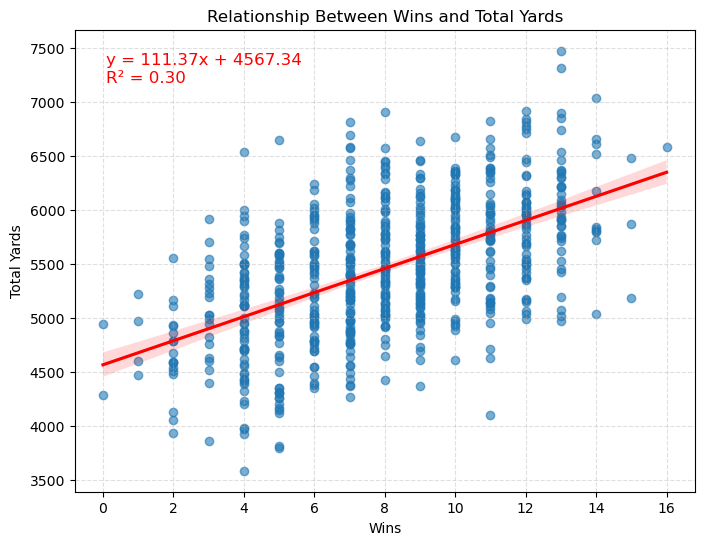

In [16]:
# Fitting linear regression line manually
x = merged_df_imputed['wins']
y = merged_df_imputed['total_yards']
slope, intercept = np.polyfit(x, y, 1)

# Calculating the equation and R²
r_value = np.corrcoef(x, y)[0, 1]
r_squared = r_value**2
equation = f"y = {slope:.2f}x + {intercept:.2f}\nR² = {r_squared:.2f}"

# Creating the plot
plt.figure(figsize=(8,6))
sns.regplot(
    data=merged_df_imputed,
    x='wins',
    y='total_yards',
    scatter_kws={'alpha':0.6},
    line_kws={'color':'red'}
)

# Annotating the equation on the plot
plt.text(
    0.05, 0.95,               # Position (in axes fraction)
    equation,
    transform=plt.gca().transAxes,
    fontsize=12,
    color='red',
    verticalalignment='top'
)

plt.title("Relationship Between Wins and Total Yards")
plt.xlabel("Wins")
plt.ylabel("Total Yards")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()



In [17]:
# Exploring the impact of penalty yards on total yards
percent_yards_lost = merged_df_imputed['Team_Penalty_Yards'] / (merged_df_imputed['Team_Penalty_Yards'] + merged_df_imputed['total_yards'])

print(f"Ratio of how many yards are lost due to penalties: {np.mean(percent_yards_lost)}")
print(f"Average number of yards per season: {np.mean(merged_df_imputed['total_yards'])}")
print(f"Average number of yards lost due to penalties: {np.mean(merged_df_imputed['total_yards']) * np.mean(percent_yards_lost)}")


Ratio of how many yards are lost due to penalties: 0.13677470966602168
Average number of yards per season: 5463.895833333333
Average number of yards lost due to penalties: 747.3227662495522


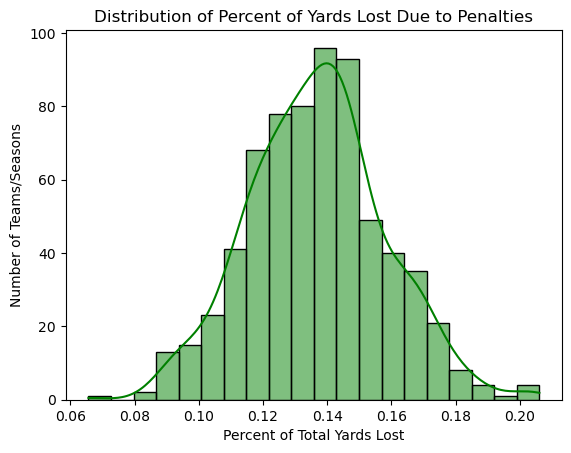

In [18]:
# Plotting the distribution of percentage of total yards being lost due to penalties
sns.histplot(percent_yards_lost, bins=20, kde=True, color='green')
plt.title("Distribution of Percent of Yards Lost Due to Penalties")
plt.xlabel("Percent of Total Yards Lost")
plt.ylabel("Number of Teams/Seasons")
plt.show()

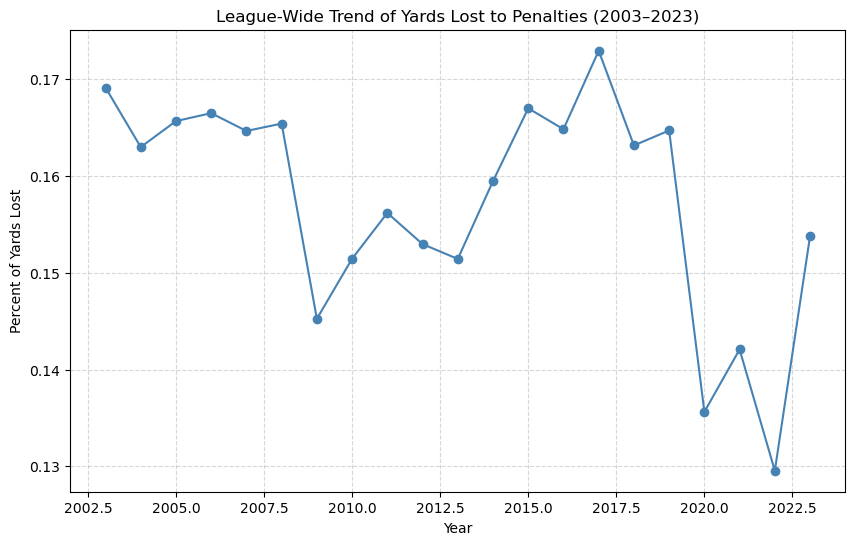

In [19]:
# taking a look at how yards lost to penalties has changed over time
yearly_ratio = merged_df_imputed.groupby('Year')['Team_Penalty_Yards'].sum() / \
               merged_df_imputed.groupby('Year')['total_yards'].sum()

yearly_ratio.plot(kind='line', marker='o', color='steelblue', figsize=(10,6))
plt.title("League-Wide Trend of Yards Lost to Penalties (2003–2023)")
plt.ylabel("Percent of Yards Lost")
plt.xlabel("Year")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()


In [20]:
# Taking a look at which variables have the highest correlation with winning
target_column = 'wins'  

corr_matrix = merged_df_imputed.corr(numeric_only=True)

top_corr = corr_matrix[target_column].drop(target_column).sort_values(ascending=False)

print("Top 5 columns most correlated with", target_column)
print(top_corr.head(5))

Top 5 columns most correlated with wins
win_loss_perc           0.997819
points_diff             0.908735
points                  0.753723
score_pct               0.685400
pass_net_yds_per_att    0.615580
Name: wins, dtype: float64


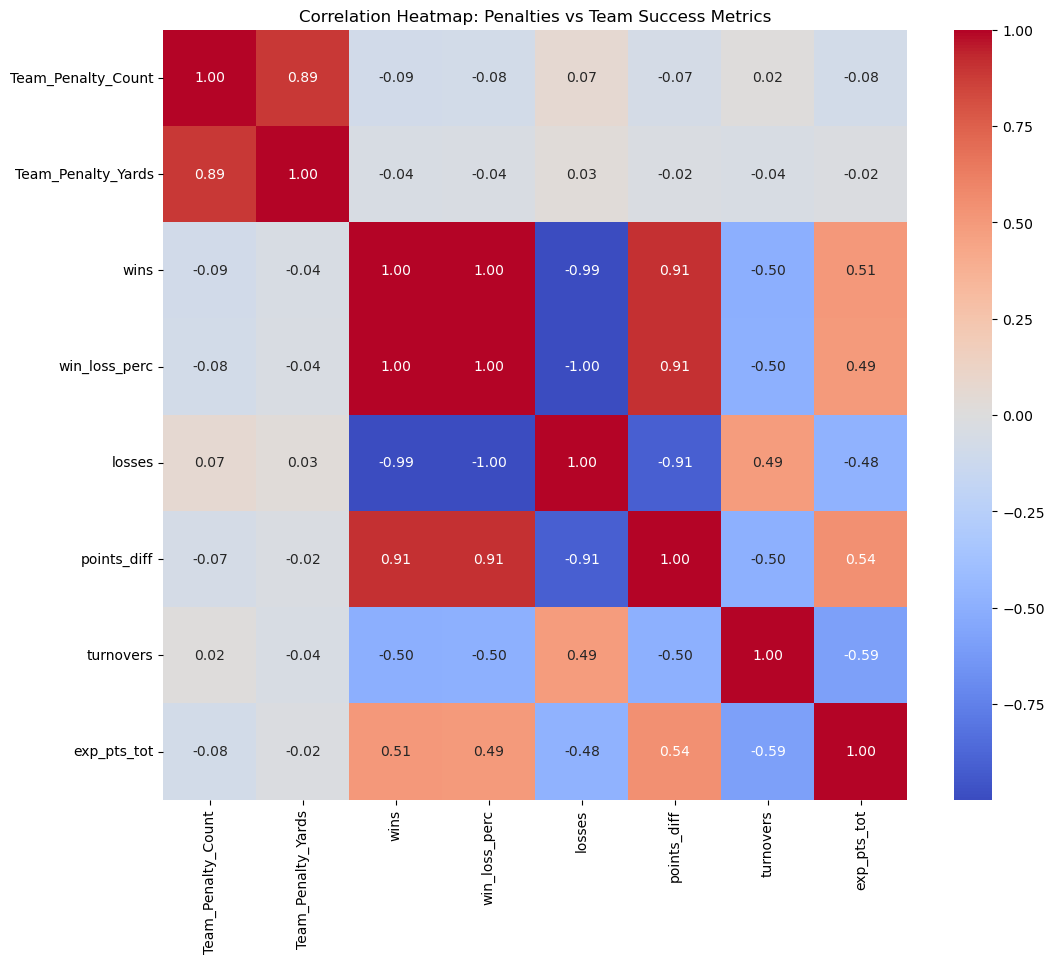

In [21]:
# looking at which variables correlate most with penalty yards
plt.figure(figsize=(12,10))
corr = merged_df_imputed[['Team_Penalty_Count', 'Team_Penalty_Yards', 'wins', 'win_loss_perc', 'losses', 'points_diff', 'turnovers', 'exp_pts_tot']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Penalties vs Team Success Metrics")
plt.show()


/var/folders/sx/2x86xg596z3_l3gtfw2t0ryr0000gn/T/ipykernel_45467/3776671616.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


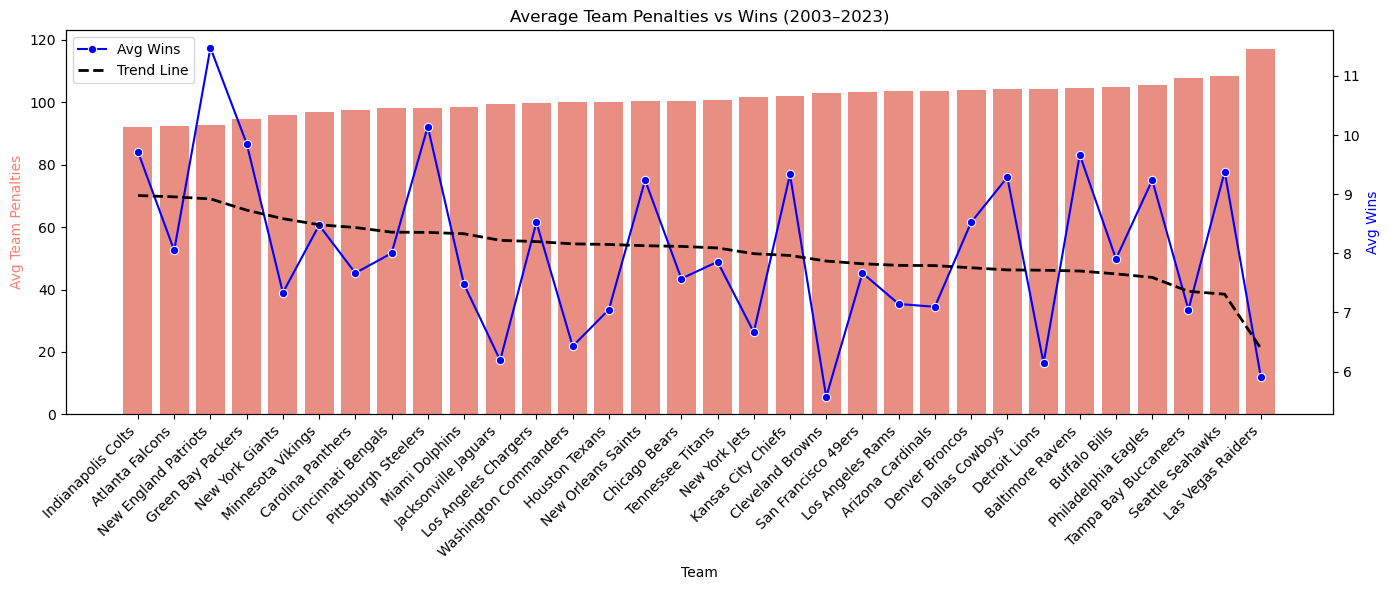

In [22]:
# Aggregating data
team_summary = merged_df_imputed.groupby('Team').agg({
    'Team_Penalty_Count': 'mean',
    'wins': 'mean'
}).reset_index()

# Sorting by penalty count
team_summary = team_summary.sort_values('Team_Penalty_Count')

# Fitting a straight regression line (linear trend)
x = team_summary['Team_Penalty_Count']
y = team_summary['wins']
slope, intercept = np.polyfit(x, y, 1)
trend_line = slope * x + intercept

# Plotting setup
fig, ax1 = plt.subplots(figsize=(14, 6))

# Making a bar plot for average penalties
sns.barplot(
    data=team_summary,
    x='Team', y='Team_Penalty_Count',
    color='salmon', ax=ax1
)
ax1.set_ylabel('Avg Team Penalties', color='salmon')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# adding a line plot for average wins
ax2 = ax1.twinx()
sns.lineplot(
    data=team_summary,
    x='Team', y='wins',
    color='blue', marker='o', label='Avg Wins', ax=ax2
)

# Adding regression trend line 
ax2.plot(
    team_summary['Team'],
    trend_line,
    color='black', linestyle='--', linewidth=2, label='Trend Line'
)

# Adding labels and title
ax2.set_ylabel('Avg Wins', color='blue')
ax2.legend(loc='upper left')
plt.title("Average Team Penalties vs Wins (2003–2023)")
plt.tight_layout()
plt.show()


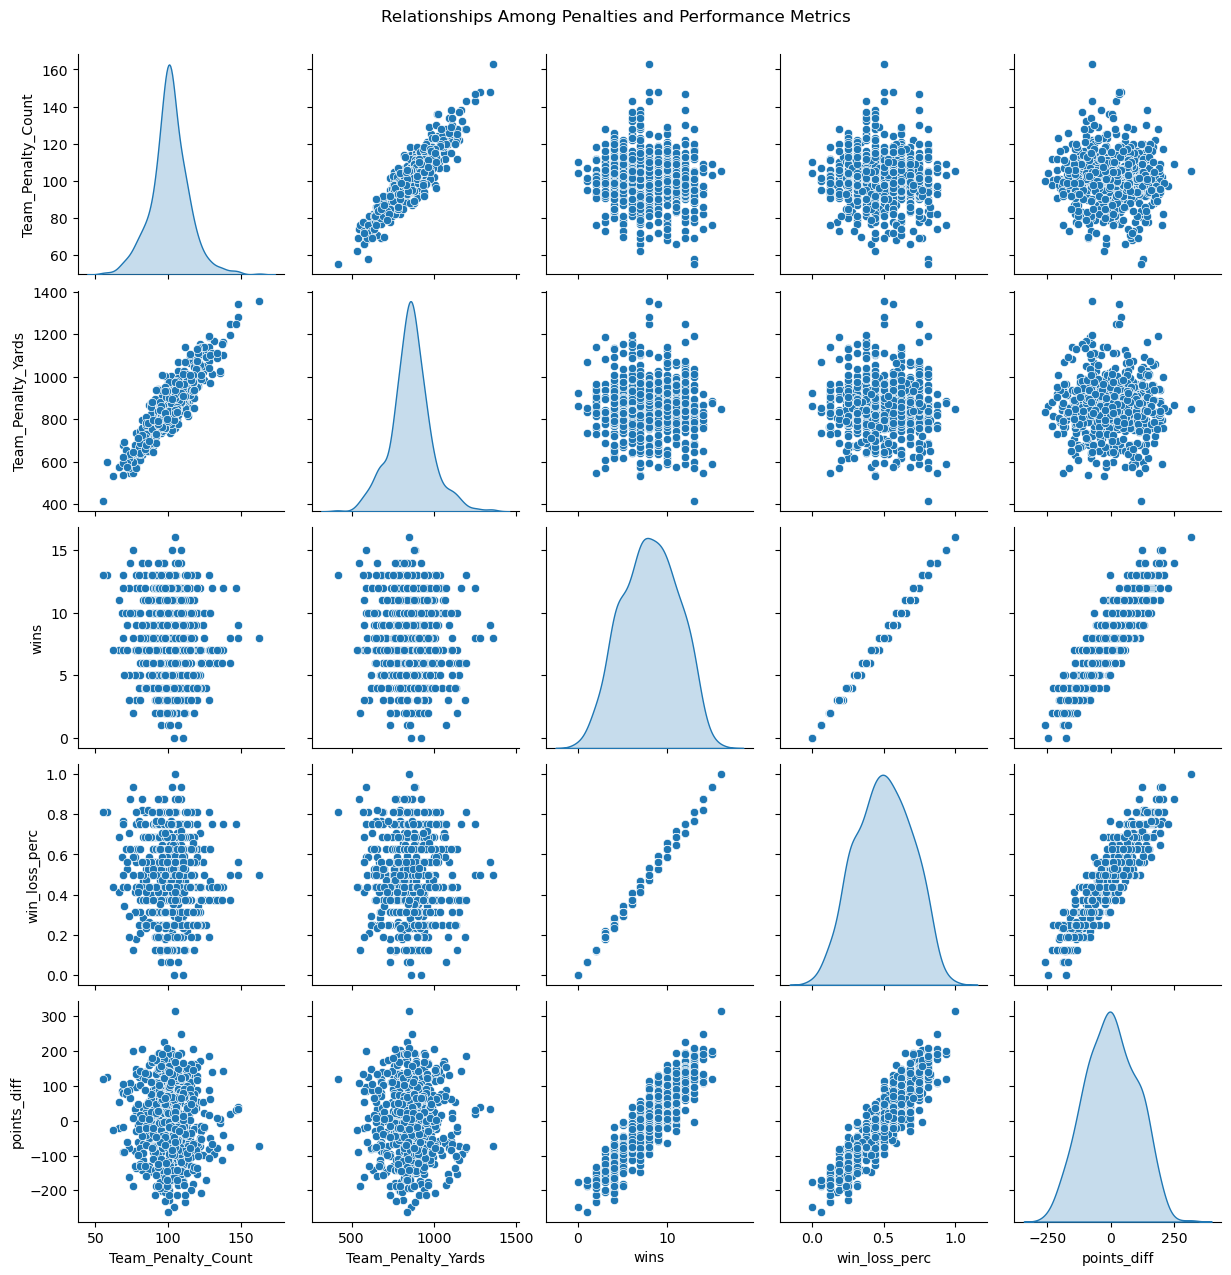

In [23]:
# taking a look at distributions and correlation plots of penalty and success variables
sns.pairplot(merged_df_imputed[['Team_Penalty_Count', 'Team_Penalty_Yards', 'wins', 'win_loss_perc', 'points_diff']], diag_kind='kde')
plt.suptitle("Relationships Among Penalties and Performance Metrics", y=1.02)
plt.show()


/var/folders/sx/2x86xg596z3_l3gtfw2t0ryr0000gn/T/ipykernel_45467/2125605346.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged_df_imputed, x='Team', y='Team_Penalty_Count', palette='coolwarm')


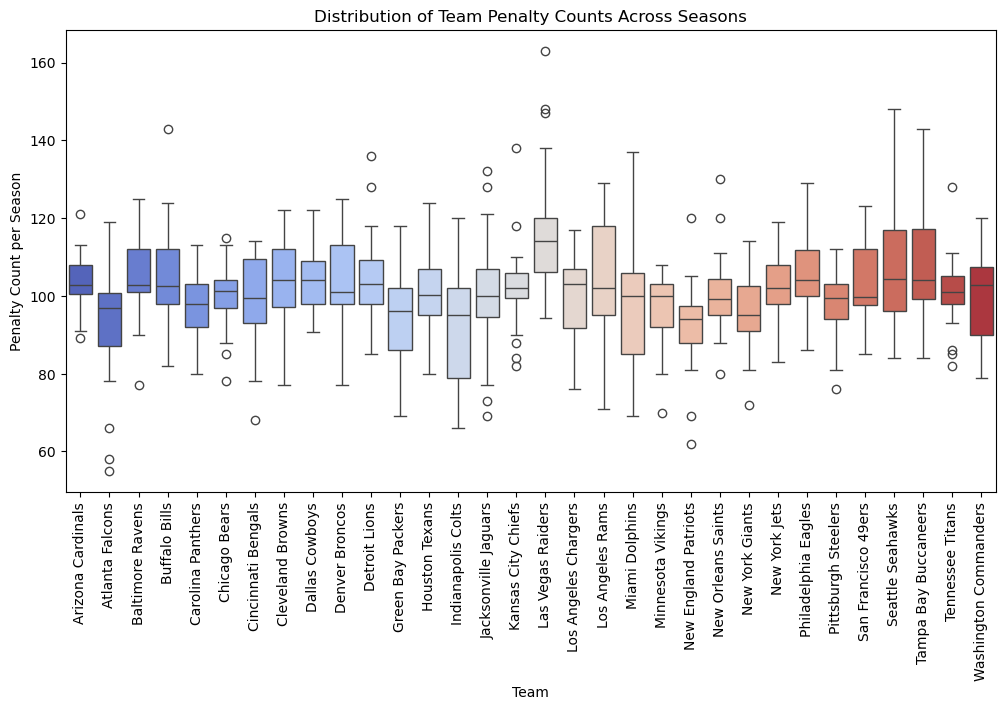

In [24]:
# looking at differences between teams and how many penalties they get
plt.figure(figsize=(12,6))
sns.boxplot(data=merged_df_imputed, x='Team', y='Team_Penalty_Count', palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Distribution of Team Penalty Counts Across Seasons")
plt.xlabel("Team")
plt.ylabel("Penalty Count per Season")
plt.show()


<Axes: xlabel='wins', ylabel='Team_Penalty_Yards'>

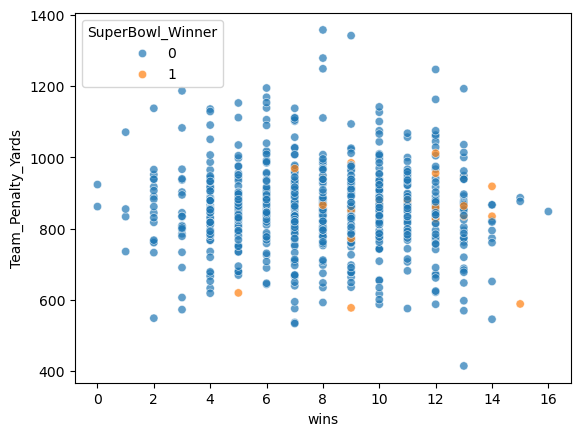

In [25]:
# listing all the past superbowl winners
super_bowl_winners = [
    {"Year": 2003, "Team": "Tampa Bay Buccaneers", "SuperBowl_Winner": 1},
    {"Year": 2004, "Team": "New England Patriots", "SuperBowl_Winner": 1},
    {"Year": 2005, "Team": "New England Patriots", "SuperBowl_Winner": 1},
    {"Year": 2006, "Team": "Pittsburgh Steelers", "SuperBowl_Winner": 1},
    {"Year": 2007, "Team": "Indianapolis Colts", "SuperBowl_Winner": 1},
    {"Year": 2008, "Team": "New York Giants", "SuperBowl_Winner": 1},
    {"Year": 2009, "Team": "Pittsburgh Steelers", "SuperBowl_Winner": 1},
    {"Year": 2010, "Team": "New Orleans Saints", "SuperBowl_Winner": 1},
    {"Year": 2011, "Team": "Green Bay Packers", "SuperBowl_Winner": 1},
    {"Year": 2012, "Team": "New York Giants", "SuperBowl_Winner": 1},
    {"Year": 2013, "Team": "Baltimore Ravens", "SuperBowl_Winner": 1},
    {"Year": 2014, "Team": "Seattle Seahawks", "SuperBowl_Winner": 1},
    {"Year": 2015, "Team": "New England Patriots", "SuperBowl_Winner": 1},
    {"Year": 2016, "Team": "Denver Broncos", "SuperBowl_Winner": 1},
    {"Year": 2017, "Team": "New England Patriots", "SuperBowl_Winner": 1},
    {"Year": 2018, "Team": "Philadelphia Eagles", "SuperBowl_Winner": 1},
    {"Year": 2019, "Team": "New England Patriots", "SuperBowl_Winner": 1},
    {"Year": 2020, "Team": "Kansas City Chiefs", "SuperBowl_Winner": 1},
    {"Year": 2021, "Team": "Tampa Bay Buccaneers", "SuperBowl_Winner": 1},
    {"Year": 2022, "Team": "Los Angeles Rams", "SuperBowl_Winner": 1},
    {"Year": 2023, "Team": "Kansas City Chiefs", "SuperBowl_Winner": 1},
]

# adding a column for super bowl winners to see if the best teams have less penalty yards
winners_df = pd.DataFrame(super_bowl_winners)

df = pd.merge( merged_df_imputed, winners_df, on=["Year", "Team"], how="left")

df["SuperBowl_Winner"] = df["SuperBowl_Winner"].fillna(0).astype(int)

sns.scatterplot(
    data=df, 
    x='wins', 
    y='Team_Penalty_Yards', 
    hue='SuperBowl_Winner', 
    alpha=0.7
)

In [32]:
# making final dataframe into a csv for running the streamlit app
merged_df_imputed.to_csv("merged_df_imputed.csv", index=False)
stats.to_csv("stats.csv", index=False)
flags.to_csv("flags.csv", index=False)

In [91]:
%%writefile app.py
# creating a .py file for the app
import numpy as np
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go



# loading in final dataframes
stats = pd.read_csv("stats.csv")
flags_orignal = pd.read_csv("CMSE_830_Midterm_dataset2.csv")
flags = pd.read_csv("flags.csv")
merged_df_imputed = pd.read_csv("merged_df_imputed.csv")
merged_df = pd.read_csv("merged_df.csv")

st.title("How Do Penalties Affect a Teams Success in the NFL?")

tabs = st.tabs(["IDA", "EDA", "Discussion"])

with tabs[0]: # Starting the IDA tab

    st.write("## IDA")
    
    st.write("### Data Sets")
    st.write("##### The first step of this project was reading in both of the data sets.")
    st.write("##### This data set has team statistics for every year and every team for the years 2003-2023.")
    st.dataframe(stats.head())
    st.write("##### This data set has penalty totals for each game from 2009-2022.")
    st.dataframe(flags_orignal.head())
    st.write("### Data Cleaning")
    st.write("##### The goal is to combine these two data sets so that we have penalty and stat totals for each team from each season spanning from 2003-2023. The first step is changing the flags data set from per game to per season and by team. To do this the home team data needs to be separated from the away team data making two different data sets. Then the numerical columns should be grouped by team and year summing all the numerical columns. This left me with two datasets each having penalty sums for each team in each year. The last step was adding together the home team and away team datasets to get full season totals. The resulting dataset included team penalty totals for each year as shown below:")
    st.dataframe(flags.head())
    st.write("##### The next step was combining the two datasets by team and year. The year had the same format in both data sets but the teams names were different. There was an additional level of complexity here because some teams have changed names and locations over the time period that our data is from. This means some teams had up to 5 different names over this span of time. For this reason the names in both data sets needed to be standardized before the data sets could be combined.")
    
    # Compacting team naming system 
    name_map = {
        # AFC East
        **dict.fromkeys(['Patriots', 'New England', 'New England Patriots'], 'New England Patriots'),
        **dict.fromkeys(['Dolphins', 'Miami', 'Miami Dolphins'], 'Miami Dolphins'),
        **dict.fromkeys(['Bills', 'Buffalo', 'Buffalo Bills'], 'Buffalo Bills'),
        **dict.fromkeys(['Jets', 'N.Y. Jets', 'NY Jets', 'New York Jets'], 'New York Jets'),
    
        # AFC North
        **dict.fromkeys(['Ravens', 'Baltimore', 'Baltimore Ravens'], 'Baltimore Ravens'),
        **dict.fromkeys(['Bengals', 'Cincinnati', 'Cincinnati Bengals'], 'Cincinnati Bengals'),
        **dict.fromkeys(['Steelers', 'Pittsburgh', 'Pittsburgh Steelers'], 'Pittsburgh Steelers'),
        **dict.fromkeys(['Browns', 'Cleveland', 'Cleveland Browns'], 'Cleveland Browns'),
    
        # AFC South
        **dict.fromkeys(['Colts', 'Indianapolis', 'Indianapolis Colts'], 'Indianapolis Colts'),
        **dict.fromkeys(['Titans', 'Tennessee', 'Tennessee Titans', 'Houston Oilers'], 'Tennessee Titans'),
        **dict.fromkeys(['Jaguars', 'Jacksonville', 'Jacksonville Jaguars'], 'Jacksonville Jaguars'),
        **dict.fromkeys(['Texans', 'Houston', 'Houston Texans'], 'Houston Texans'),
    
        # AFC West
        **dict.fromkeys(['Chiefs', 'Kansas City', 'Kansas City Chiefs'], 'Kansas City Chiefs'),
        **dict.fromkeys(['Broncos', 'Denver', 'Denver Broncos'], 'Denver Broncos'),
        **dict.fromkeys(['Raiders', 'Oakland', 'Oakland Raiders', 'Los Angeles Raiders', 'Las Vegas', 'Las Vegas Raiders'], 'Las Vegas Raiders'),
        **dict.fromkeys(['Chargers', 'San Diego', 'San Diego Chargers', 'LA Chargers', 'Los Angeles Chargers'], 'Los Angeles Chargers'),
    
        # NFC East
        **dict.fromkeys(['Eagles', 'Philadelphia', 'Philadelphia Eagles'], 'Philadelphia Eagles'),
        **dict.fromkeys(['Cowboys', 'Dallas', 'Dallas Cowboys'], 'Dallas Cowboys'),
        **dict.fromkeys(['Commanders', 'Washington', 'Washington Redskins', 'Washington Football Team', 'Washington Commanders'], 'Washington Commanders'),
        **dict.fromkeys(['Giants', 'N.Y. Giants', 'NY Giants', 'New York Giants'], 'New York Giants'),
    
        # NFC North
        **dict.fromkeys(['Packers', 'Green Bay', 'Green Bay Packers'], 'Green Bay Packers'),
        **dict.fromkeys(['Vikings', 'Minnesota', 'Minnesota Vikings'], 'Minnesota Vikings'),
        **dict.fromkeys(['Bears', 'Chicago', 'Chicago Bears'], 'Chicago Bears'),
        **dict.fromkeys(['Lions', 'Detroit', 'Detroit Lions'], 'Detroit Lions'),
    
        # NFC South
        **dict.fromkeys(['Panthers', 'Carolina', 'Carolina Panthers'], 'Carolina Panthers'),
        **dict.fromkeys(['Saints', 'New Orleans', 'New Orleans Saints'], 'New Orleans Saints'),
        **dict.fromkeys(['Buccaneers', 'Tampa Bay', 'Tampa Bay Buccaneers'], 'Tampa Bay Buccaneers'),
        **dict.fromkeys(['Falcons', 'Atlanta', 'Atlanta Falcons'], 'Atlanta Falcons'),
    
        # NFC West
        **dict.fromkeys(['Cardinals', 'Arizona', 'Arizona Cardinals'], 'Arizona Cardinals'),
        **dict.fromkeys(['Seahawks', 'Seattle', 'Seattle Seahawks'], 'Seattle Seahawks'),
        **dict.fromkeys(['49ers', 'San Francisco', 'San Francisco 49ers'], 'San Francisco 49ers'),
        **dict.fromkeys(['Rams', 'St. Louis', 'St. Louis Rams', 'LA Rams', 'Los Angeles Rams'], 'Los Angeles Rams'),
    }
    st.write("##### Type or select any version of a team name — historical or short — and get the standardized full name. Make sure to capitalize the team name you use.")
    
    # Adding a dropdown or free text input
    user_input = st.text_input("Enter a team name:", placeholder="e.g. NY Jets, Oakland, Washington Redskins")
    
    if user_input:
        normalized = name_map.get(user_input.strip(), "Unknown Team")
        st.success(f"**Standardized Name:** {normalized}")
    
    st.write("##### This is a list of all of the final standardized names used for both datasets")
    
    with st.expander("Show all standardized team names"):
        st.write(sorted(set(name_map.values())))
    
    st.write("##### After combining the two data sets this is what the result looks like.")
    st.dataframe(merged_df.head())
    st.write("### Data Imputation")
    st.write("##### Now that the two data sets have been combined there are many rows with missing values. This is because the stats dataset covers years from 2003-2023 while the flags dataset only goes from 2009-2022. To fix this I will use stochastic regression to impute the missing values. This will allow for the data to be imputed accurately while still having same variance. The standard deviation of the imputed columns are as follows: Accepted_Penalty_Count residual std = 5.9150, Penalty_Yards residual std = 52.3693, Team_Penalty_Count residual std = 4.1602, Team_Penalty_Yards residual std = 38.1223. After imputation the data set looks like this and it is ready for EDA.")
    st.dataframe(merged_df_imputed.head())

with tabs[1]:
    st.write("## EDA")
    st.write("##### In this section I will explore the data using a variety of plots. All plots will be shown here regardless of if they turn out to be useful for answering the overarching project question or not. The plots that turn out to be the most relevant will be used in the discussion section.")

    st.write("##### When doing exploratory data analysis I always like to start by looking at a correlation matrix to see where I might be able to find relationships within the data. As you can see here, the penalty variables have very small correlations with all the other variables so finding obvious relationships may be a difficult task. For this correlation matrix there are a lot of variables and the small size makes it hard to read. To help with this you can hover your cursor over the matrix and it will tell you the variables you are hovering over and their correlation.")
    # Computing correlation matrix
    corr = merged_df_imputed.corr(numeric_only=True)
    
    # Creating interactive Plotly heatmap
    fig = px.imshow(
        corr,
        text_auto=".2f",
        color_continuous_scale='RdBu_r',
        aspect='auto',
        title="Correlation Plot of Numeric Variables"
    )
    
    fig.update_layout(
        width=1000,
        height=700,
        title_x=0.25,
        title_font_size=20
    )

    # Displaying in Streamlit
    st.plotly_chart(fig, use_container_width=True)

    st.write("##### This is a more user friendly option than the massive correlation matrix. Here you can select the variables you want to look at and it will show you the distributions of those variables and the correlation scatterplot for each combination.")
    
    # selecting variables
    default_vars = ['Team_Penalty_Count', 'Team_Penalty_Yards', 'wins', 'win_loss_perc', 'points_diff']
    available_vars = list(merged_df_imputed.select_dtypes(include='number').columns)
    
    selected_vars = st.multiselect(
        "Select numeric variables to include in the pairplot:",
        options=available_vars,
        default=default_vars,
        key="pairplot_vars"
    )
    
    # Generating the plot only if at least 2 variables selected 
    if len(selected_vars) >= 2:
        fig = sns.pairplot(merged_df_imputed[selected_vars], diag_kind='kde')
        fig.fig.suptitle("Relationships Among Selected Variables", y=1.02)
        st.pyplot(fig)
    else:
        st.warning("Please select at least two numeric variables to display the pairplot.")

    st.write("##### I am most interested in the relatinship between penalty yards and winning because these two variables are directly related to my overall project question. For this reason I chose to plot the correlation scatter plot for these two variables and include the correlation line. You can hover over each point to see the team, year, and specific values for that point.")
    
    # making a correlation plot for wins and penalty yards
    x = merged_df_imputed['wins']
    y = merged_df_imputed['Team_Penalty_Yards']
    
    slope, intercept = np.polyfit(x, y, 1)
    r_value = np.corrcoef(x, y)[0, 1]
    r_squared = r_value**2
    equation = f"y = {slope:.2f}x + {intercept:.2f}   |   correlation = {r_value:.2f}"
    
    # Computing fitted line
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept

    fig = px.scatter(
        merged_df_imputed,
        x='wins',
        y='Team_Penalty_Yards',
        hover_data=['Team', 'Year'],  # show team + year on hover
        opacity=0.7,
        title="Relationship Between Wins and Team Penalty Yards",
    )
    
    # Adding regression line
    fig.add_scatter(
        x=x_line,
        y=y_line,
        mode='lines',
        name='Regression Line',
        line=dict(color='red')
    )

    # Annotating the equation on the plot
    fig.add_annotation(
        xref="paper", yref="paper",
        x=0.05, y=0.95,
        text=equation,
        showarrow=False,
        font=dict(size=14, color="red")
    )
    
    fig.update_layout(
        xaxis_title="Wins",
        yaxis_title="Team Penalty Yards",
        template="simple_white",
        hovermode="closest"
    )
    
    st.plotly_chart(fig, use_container_width=True, key="corr")
    st.write(f"**Regression Equation:** {equation}")

    st.write("##### This plot show the distribution of the percentage of total yards that are lost due to penalties. This information is helpful for grasping how much losing penalty yards affects a teams total yards. You can use the slider to change how many bins the histogram has.")

    # Calculate metric
    merged_df_imputed['percent_yards_lost'] = (
        merged_df_imputed['Team_Penalty_Yards'] /
        (merged_df_imputed['Team_Penalty_Yards'] + merged_df_imputed['total_yards'])
    )
    
    # Creating the initial plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(
        merged_df_imputed['percent_yards_lost'],
        bins=20,  # temporary default
        kde=True,
        color='green',
        ax=ax
    )
    ax.set_title("Distribution of Percent of Yards Lost Due to Penalties", fontsize=14)
    ax.set_xlabel("Percent of Total Yards Lost")
    ax.set_ylabel("Count")
    ax.grid(True, linestyle='--', alpha=0.4)
    
    # Adding controls directly below the plot
    st.markdown("##### Plot Settings")
    bins = st.slider("Number of bins", min_value=5, max_value=50, value=20, key="bins_main")
    show_kde = st.checkbox("Show KDE Curve", value=True, key="checkbox_main")
    
    # Updating the plot with new settings
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(
        merged_df_imputed['percent_yards_lost'],
        bins=bins,
        kde=show_kde,
        color='green',
        ax=ax
    )
    ax.set_title("Distribution of Percent of Yards Lost Due to Penalties", fontsize=14)
    ax.set_xlabel("Percent of Total Yards Lost")
    ax.set_ylabel("Count")
    ax.grid(True, linestyle='--', alpha=0.4)
    
    # Displaying figure
    st.pyplot(fig)

    # Displaying summary info
    mean_ratio = merged_df_imputed['percent_yards_lost'].mean()
    st.write(f"**Average percent of yards lost to penalties:** {mean_ratio:.2%}")

    st.write("##### This plot is related to the histogram above. It shows how the percent of total yards lost due to penalties has changed over the seasons. As you can see the it remains between 13% and 17% making it a pretty consistent time trend. You can use the sliding bar above the plot to adjust which years are shown in the plot.")
    
    # Adding user controls 
    year_range = st.slider(
        "Select Year Range",
        min_value=int(merged_df_imputed['Year'].min()),
        max_value=int(merged_df_imputed['Year'].max()),
        value=(2003, 2023),
        key="year_slider"
    )
    
    show_grid = st.checkbox("Show Grid", value=True, key="show_grid")
    show_points = st.checkbox("Show Data Points", value=True, key="show_points")
    
    # Computing yearly ratios
    yearly_ratio = (
        merged_df_imputed.groupby('Year')['Team_Penalty_Yards'].sum() /
        merged_df_imputed.groupby('Year')['total_yards'].sum()
    )
    
    # Filtering by year range
    yearly_ratio = yearly_ratio.loc[
        (yearly_ratio.index >= year_range[0]) & (yearly_ratio.index <= year_range[1])
    ]
    
    # Creating plot 
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(
        yearly_ratio.index,
        yearly_ratio.values * 100,  # convert to percent
        marker='o' if show_points else '',
        color='steelblue',
        linewidth=2
    )
    ax.set_title("League-Wide Trend of Yards Lost to Penalties (2003–2023)", fontsize=14)
    ax.set_ylabel("Percent of Yards Lost (%)", fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.grid(show_grid, linestyle='--', alpha=0.5)
    
    # Displaying plot in Streamlit 
    st.pyplot(fig)

    st.write("##### This plot shows the average number of wins for each team and the average number of penalty yards for each team over the 20 year span of the data. This graph clearly shows that the teams with the most penalty yards typically also have the most losses. To see precise values hover your cursor over the graph.")
    # Aggregating by team
    team_summary = merged_df_imputed.groupby('Team').agg({
        'Team_Penalty_Yards': 'mean',
        'wins': 'mean'
    }).reset_index()
    
    # Sorting by penalties
    team_summary = team_summary.sort_values('Team_Penalty_Yards')
    
    # Computing linear regression for straight trend line
    x = team_summary['Team_Penalty_Yards']
    y = team_summary['wins']
    slope, intercept = np.polyfit(x, y, 1)
    trend_line = slope * x + intercept

    # creating a plot showing wins and penalty yards for each team over all seasons
    fig = go.Figure()
    
    # creating bar chart for penalties
    fig.add_trace(go.Bar(
        x=team_summary['Team'],
        y=team_summary['Team_Penalty_Yards'],
        name='Avg Team Penaltiy Yards',
        marker_color='salmon',
        yaxis='y1',
        hovertemplate="<b>%{x}</b><br>Avg Penalties: %{y:.2f}<extra></extra>"
    ))
    
        # adding line for average wins
    fig.add_trace(go.Scatter(
        x=team_summary['Team'],
        y=team_summary['wins'],
        mode='lines+markers',
        name='Avg Wins',
        marker=dict(color='blue', size=8),
        line=dict(color='blue', width=2),
        yaxis='y2',
        hovertemplate="<b>%{x}</b><br>Avg Wins: %{y:.2f}<extra></extra>"
    ))
    # adding regression trend line to highlight trend
    fig.add_trace(go.Scatter(
        x=team_summary['Team'],
        y=trend_line,
        mode='lines',
        name='Trend Line',
        line=dict(color='black', dash='dash'),
        yaxis='y2',
        hovertemplate="<b>%{x}</b><br>Trend Wins: %{y:.2f}<extra></extra>"
    ))
    
        # customizing the layout
    fig.update_layout(
            title=dict(
                text="Average Team Penalty Yards vs Wins (2003–2023)",
                x=0.15,
                font=dict(size=20)
            ),
            xaxis=dict(title='Team', tickangle=45),
            yaxis=dict(title='Avg Team Penalty Yards', color='salmon'),
            yaxis2=dict(
                title='Avg Wins',
                overlaying='y',
                side='right',
                color='blue'
            ),
            legend=dict(
                orientation='h',
                yanchor='top',
                y=1.1,
                xanchor='center',
                x=0.5,
                font=dict(size=14)
            ),
            hovermode='x unified',
            template='plotly_white',
            width=2200,
            height=600,
            margin=dict(l=80, r=80, t=100, b=150)
        )

    st.plotly_chart(fig, use_container_width=True, key = "plot")

    st.write("##### This plot shows the distributions of team penalty counts across seasons using box plots. This plot would be useful for comparing a few teams to see how their penalty counts differ. You can select which teams you would like included in the plot.")
    # Letting user choose variables interactively 
    teams = merged_df_imputed['Team'].unique()
    selected_teams = st.multiselect(
        "Select teams to include:",
        options=teams,
        default=teams,
        key="team_boxplot"
    )
    
    if len(selected_teams) > 0:
        filtered_df = merged_df_imputed[merged_df_imputed['Team'].isin(selected_teams)]
    
        fig, ax = plt.subplots(figsize=(12, 6))
        sns.boxplot(
            data=filtered_df,
            x='Team',
            y='Team_Penalty_Count',
            palette='coolwarm',
            ax=ax
        )
        ax.set_title("Distribution of Team Penalty Counts Across Seasons", fontsize=14)
        ax.set_xlabel("Team")
        ax.set_ylabel("Penalty Count per Season")
        plt.xticks(rotation=90)
        st.pyplot(fig)
    else:
        st.warning("Please select at least one team to display the boxplot.")

    st.write("##### This plot shows the scatter plot comparing wins and team penalty yards. The unique thing about this plot is that it highlights all of the super bowl winners. The super bowl winner is considered to be one of the best teams from each season so this plot helps highlight how the best teams differ from all the other teams. You can choose which super bowl winner to display by choosing the year that each champion won.")
    # Super Bowl winners data 
    super_bowl_winners = [
        {"Year": 2003, "Team": "Tampa Bay Buccaneers", "SuperBowl_Winner": 1},
        {"Year": 2004, "Team": "New England Patriots", "SuperBowl_Winner": 1},
        {"Year": 2005, "Team": "New England Patriots", "SuperBowl_Winner": 1},
        {"Year": 2006, "Team": "Pittsburgh Steelers", "SuperBowl_Winner": 1},
        {"Year": 2007, "Team": "Indianapolis Colts", "SuperBowl_Winner": 1},
        {"Year": 2008, "Team": "New York Giants", "SuperBowl_Winner": 1},
        {"Year": 2009, "Team": "Pittsburgh Steelers", "SuperBowl_Winner": 1},
        {"Year": 2010, "Team": "New Orleans Saints", "SuperBowl_Winner": 1},
        {"Year": 2011, "Team": "Green Bay Packers", "SuperBowl_Winner": 1},
        {"Year": 2012, "Team": "New York Giants", "SuperBowl_Winner": 1},
        {"Year": 2013, "Team": "Baltimore Ravens", "SuperBowl_Winner": 1},
        {"Year": 2014, "Team": "Seattle Seahawks", "SuperBowl_Winner": 1},
        {"Year": 2015, "Team": "New England Patriots", "SuperBowl_Winner": 1},
        {"Year": 2016, "Team": "Denver Broncos", "SuperBowl_Winner": 1},
        {"Year": 2017, "Team": "New England Patriots", "SuperBowl_Winner": 1},
        {"Year": 2018, "Team": "Philadelphia Eagles", "SuperBowl_Winner": 1},
        {"Year": 2019, "Team": "New England Patriots", "SuperBowl_Winner": 1},
        {"Year": 2020, "Team": "Kansas City Chiefs", "SuperBowl_Winner": 1},
        {"Year": 2021, "Team": "Tampa Bay Buccaneers", "SuperBowl_Winner": 1},
        {"Year": 2022, "Team": "Los Angeles Rams", "SuperBowl_Winner": 1},
        {"Year": 2023, "Team": "Kansas City Chiefs", "SuperBowl_Winner": 1},
    ]
    
    # Merging data 
    winners_df = pd.DataFrame(super_bowl_winners)
    df = pd.merge(merged_df_imputed, winners_df, on=["Year", "Team"], how="left")
    df["SuperBowl_Winner"] = df["SuperBowl_Winner"].fillna(0).astype(int)
    
    # Adding inline filter controls 
    st.markdown("### 🔍 Filter Options")
    col1, col2 = st.columns([1, 3])
    
    with col1:
        st.write("")  # spacer
    
    with col2:
        years = sorted(df["Year"].unique())
        selected_years = st.multiselect(
            "Select Years to Display",
            options=years,
            default=years,
            key="year_selector_scatter"
        )
    
    # Filtering data 
    filtered_df = df[df["Year"].isin(selected_years)]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(
        data=filtered_df,
        x="wins",
        y="Team_Penalty_Yards",
        hue="SuperBowl_Winner",
        palette={0: "green", 1: "red"},
        alpha=0.7,
        ax=ax
    )
    ax.set_title("Wins vs Team Penalty Yards (Super Bowl Winners Highlighted)", fontsize=14)
    ax.set_xlabel("Wins")
    ax.set_ylabel("Team Penalty Yards")
    ax.grid(True, linestyle="--", alpha=0.5)
    
    st.pyplot(fig)


with tabs[2]:
    # showing the dataframe
    st.write("### Dataset Preview")
    st.write("##### This dataset includes team metrics for full seasons. Each row in the dataset includes information for one team for one year. This data will be used to see how penalties during a season impacts a teams outcome.")
    st.dataframe(merged_df_imputed.head())
    st.write("##### The next step was combining the two datasets by team and year")
    
    # making a correlation plot for wins and penalty yards
    x = merged_df_imputed['wins']
    y = merged_df_imputed['Team_Penalty_Yards']
    
    slope, intercept = np.polyfit(x, y, 1)
    r_value = np.corrcoef(x, y)[0, 1]
    r_squared = r_value**2
    equation = f"y = {slope:.2f}x + {intercept:.2f}   |   correlation = {r_value:.2f}"
    
    # Computing fitted line
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept
    
    fig = px.scatter(
        merged_df_imputed,
        x='wins',
        y='Team_Penalty_Yards',
        hover_data=['Team', 'Year'],  # show team + year on hover
        opacity=0.7,
        title="Relationship Between Wins and Team Penalty Yards",
    )
    
    # Adding regression line
    fig.add_scatter(
        x=x_line,
        y=y_line,
        mode='lines',
        name='Regression Line',
        line=dict(color='red')
    )

    # Annotating the equation on the plot
    fig.add_annotation(
        xref="paper", yref="paper",
        x=0.05, y=0.95,
        text=equation,
        showarrow=False,
        font=dict(size=14, color="red")
    )
    
    fig.update_layout(
        xaxis_title="Wins",
        yaxis_title="Team Penalty Yards",
        template="simple_white",
        hovermode="closest"
    )
    
    st.plotly_chart(fig, use_container_width=True)
    st.write(f"**Regression Equation:** {equation}")
    
    st.write("##### This scatterplot shows that there is almost no correlation between wins and Penalty yards directly. However, this does not necessarily mean that there is no causation. In the next plot we will show this same relationship with a different method.")
    
    # Aggregating by team
    team_summary = merged_df_imputed.groupby('Team').agg({
        'Team_Penalty_Yards': 'mean',
        'wins': 'mean'
    }).reset_index()
    
    # Sorting by penalties
    team_summary = team_summary.sort_values('Team_Penalty_Yards')
    
    # Computing linear regression for straight trend line
    x = team_summary['Team_Penalty_Yards']
    y = team_summary['wins']
    slope, intercept = np.polyfit(x, y, 1)
    trend_line = slope * x + intercept

    # creating a plot showing wins and penalty yards for each team over all seasons
    fig = go.Figure()
    
    # creating bar chart for penalties
    fig.add_trace(go.Bar(
        x=team_summary['Team'],
        y=team_summary['Team_Penalty_Yards'],
        name='Avg Team Penaltiy Yards',
        marker_color='salmon',
        yaxis='y1',
        hovertemplate="<b>%{x}</b><br>Avg Penalties: %{y:.2f}<extra></extra>"
    ))
    
        # adding line for average wins
    fig.add_trace(go.Scatter(
        x=team_summary['Team'],
        y=team_summary['wins'],
        mode='lines+markers',
        name='Avg Wins',
        marker=dict(color='blue', size=8),
        line=dict(color='blue', width=2),
        yaxis='y2',
        hovertemplate="<b>%{x}</b><br>Avg Wins: %{y:.2f}<extra></extra>"
    ))
    
        # adding regression trend line to highlight trend
    fig.add_trace(go.Scatter(
        x=team_summary['Team'],
        y=trend_line,
        mode='lines',
        name='Trend Line',
        line=dict(color='black', dash='dash'),
        yaxis='y2',
        hovertemplate="<b>%{x}</b><br>Trend Wins: %{y:.2f}<extra></extra>"
    ))
    
        # customizing the layout
    fig.update_layout(
            title=dict(
                text="Average Team Penalty Yards vs Wins (2003–2023)",
                x=0.15,
                font=dict(size=20)
            ),
            xaxis=dict(title='Team', tickangle=45),
            yaxis=dict(title='Avg Team Penalty Yards', color='salmon'),
            yaxis2=dict(
                title='Avg Wins',
                overlaying='y',
                side='right',
                color='blue'
            ),
            legend=dict(
                orientation='h',
                yanchor='top',
                y=1.1,
                xanchor='center',
                x=0.5,
                font=dict(size=14)
            ),
            hovermode='x unified',
            template='plotly_white',
            width=2200,
            height=600,
            margin=dict(l=80, r=80, t=100, b=150)
        )

    st.plotly_chart(fig, use_container_width=True)
    
    st.write("##### This plot clearly shows that the teams with more penalty yards have less wins. The dashed black line smooths out the noisy data to reveal the underlying trend in the data. This plot proves that there is at least some relationship between the penalty yards and wins. This relationship may be better explained by including total yards in the discussion.")
    
    # showing the relationship between total yards and wins
    x = merged_df_imputed['wins']
    y = merged_df_imputed['total_yards']
    
    slope, intercept = np.polyfit(x, y, 1)
    r_value = np.corrcoef(x, y)[0, 1]
    r_squared = r_value**2
    equation = f"y = {slope:.2f}x + {intercept:.2f}   |   correlation = {r_value:.2f}"
    
    # Computing fitted line
    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept
    
    fig = px.scatter(
        merged_df_imputed,
        x='wins',
        y='total_yards',
        hover_data=['Team', 'Year'],  # show team + year on hover
        opacity=0.7,
        title="Relationship Between Wins and Total Yards",
    )
    
    # Adding regression line
    fig.add_scatter(
        x=x_line,
        y=y_line,
        mode='lines',
        name='Regression Line',
        line=dict(color='red')
    )

    # Annotating the equation on the plot
    fig.add_annotation(
        xref="paper", yref="paper",
        x=0.05, y=0.95,
        text=equation,
        showarrow=False,
        font=dict(size=14, color="red")
    )
    fig.update_layout(
        xaxis_title="Wins",
        yaxis_title="total_yards",
        template="simple_white",
        hovermode="closest"
    )
    st.plotly_chart(fig, use_container_width=True)
    
    st.write("##### The consequence of getting a penalty is always a loss of yards but the amount of yard varies based on the type of penalty. This means that getting a penalty directly reduces the total yards of a team, which in turn indirectly affects if the team wins or not. ")
    st.write("##### On average 13.7% of the yards a team earn end up being lost due to penalties. A team loses an average of 747 yards due to penalties each season. However, teams earn an average of 5464 yards per season. This goes to show that teams earn way more yards than they lose due to penalties which is why penalty yards has a small correlation with winning.")
    
    # Calculating metrics
    merged_df_imputed['percent_yards_lost'] = (
        merged_df_imputed['Team_Penalty_Yards'] /
        (merged_df_imputed['Team_Penalty_Yards'] + merged_df_imputed['total_yards'])
    )
    
    # Displaying summary info
    mean_ratio = merged_df_imputed['percent_yards_lost'].mean()
    st.write(f"**Average percent of yards lost to penalties:** {mean_ratio:.2%}")
    
    # Creating the initial plot
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(
        merged_df_imputed['percent_yards_lost'],
        bins=20,  # temporary default
        kde=True,
        color='green',
        ax=ax
    )
    ax.set_title("Distribution of Percent of Yards Lost Due to Penalties", fontsize=14)
    ax.set_xlabel("Percent of Total Yards Lost")
    ax.set_ylabel("Count")
    ax.grid(True, linestyle='--', alpha=0.4)
    
    # Adding controls directly below the plot
    st.markdown("##### Plot Settings")
    bins = st.slider("Number of bins", min_value=5, max_value=50, value=20, key="bins_secondary")
    show_kde = st.checkbox("Show KDE Curve", value=True, key="checkbox_secondary")

    # Updating the plot with new settings
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(
        merged_df_imputed['percent_yards_lost'],
        bins=bins,
        kde=show_kde,
        color='green',
        ax=ax
    )
    ax.set_title("Distribution of Percent of Yards Lost Due to Penalties", fontsize=14)
    ax.set_xlabel("Percent of Total Yards Lost")
    ax.set_ylabel("Count")
    ax.grid(True, linestyle='--', alpha=0.4)
    
    # displaying figure
    st.pyplot(fig)



Overwriting app.py


In [92]:
! streamlit run app.py



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.0.63:8501

/Users/beaubelkowski/Downloads/app.py:395: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


^C
  Stopping...
